<a href="https://colab.research.google.com/github/ShilviaIrani/202255202004-Shilvia/blob/master/Tugas2deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Necessary Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
# Import the train_test_split function
from sklearn.model_selection import train_test_split

In [2]:
# Load and Transform Data
data_dir = '/content/drive/MyDrive/Deep learning '  # Ganti  dengan nama folder Anda
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)  # 20% untuk validasi

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=(224, 224),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')


Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [3]:
# Get class names from the train generator
class_names = train_generator.class_indices

# Create a list of file paths and their corresponding labels
file_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file_name))
        labels.append(class_names[class_name])

# Create a DataFrame from the file paths and labels
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [4]:
# Splitting the data
train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=8)
train_df, valid_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=8)

# Check the lengths
print('Train length:', len(train_df), 'Validation length:', len(valid_df), 'Test length:', len(test_df))

Train length: 576 Validation length: 144 Test length: 480


In [5]:
# Data Augmentation
height, width, channels = 128, 128, 3
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Convert 'label' column to string type
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


# Correct x_col to 'file_path'
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected x_col
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    valid_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected x_col
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected x_col
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 576 validated image filenames belonging to 4 classes.
Found 144 validated image filenames belonging to 4 classes.
Found 480 validated image filenames belonging to 4 classes.


In [6]:
# Data Preprocessing and Model Definition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Training the Model
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected column names to match DataFrame
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size,
    errors='ignore'  # Ignore corrupted images
)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=valid_gen,
    validation_steps=len(valid_df) // batch_size,
    epochs=50
)


Found 576 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 365s 40s/step - accuracy: 0.3629 - loss: 2.1478 - val_accuracy: 0.9766 - val_loss: 0.2026
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - accuracy: 0.8511 - loss: 0.4124 - val_accuracy: 0.9766 - val_loss: 0.1119
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - accuracy: 0.9093 - loss: 0.2460 - val_accuracy: 0.9922 - val_loss: 0.0468
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.9493 - loss: 0.1336 - val_accuracy: 0.9922 - val_loss: 0.0343
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 9s/step - accuracy: 0.9703 - loss: 0.0991 - val_accuracy: 0.9922 - val_loss: 0.0274
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 85s 9s/step - accuracy: 0.9745 - loss: 0.0925 - val_accuracy: 0.9922 - val_loss: 0.0206
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.9788 - loss: 0.0765 - val_accuracy: 0.9922 - val_loss: 0.0272
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.9790 - loss: 0.0697 - val_accuracy: 0.9922 - val_loss: 0.0218
Epoch 

In [8]:
# Model Evaluation
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_df) // batch_size)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 220s 36s/step - accuracy: 1.0000 - loss: 9.3754e-04
Test Loss: 0.0009, Test Accuracy: 1.0000


In [11]:
# Get true classes and predicted classes for confusion matrix
true_classes = test_gen.classes  # Get true labels from the generator
predicted_probs = model.predict(test_gen, steps=len(test_df) // batch_size) # Get predicted probabilities
predicted_classes = np.argmax(predicted_probs, axis=1) # Get predicted labels from probabilities

7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step


In [15]:
# Predict on the entire test set by removing the 'steps' argument
predicted_probs = model.predict(test_gen)
predicted_classes = np.argmax(predicted_probs, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step


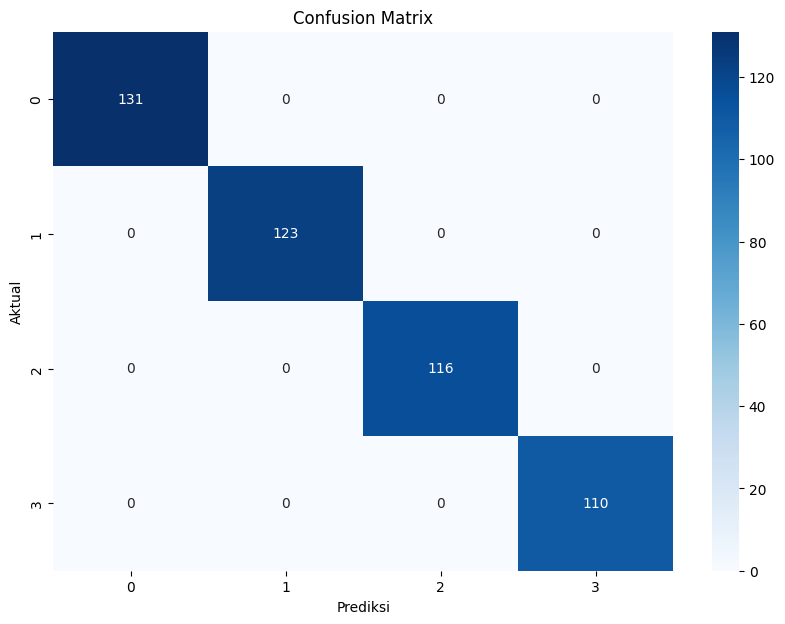

In [16]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=list(test_gen.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       123
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00       110

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [18]:
# Grad-CAM Visualization
import cv2

def get_gradcam(model, img, layer_name):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Args:
        model: The trained model.
        img: The input image.
        layer_name: The name of the convolutional layer to visualize.

    Returns:
        Heatmap overlayed on the image.
    """
    # Preprocess the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Rescale
    preds = model.predict(img)  # Make prediction to define model output
    class_idx = np.argmax(preds[0])

    # Get the gradient of the top predicted class
    # Get the layer to visualize from the VGG16 model (base model)
    vgg16_model = model.get_layer('vgg16')
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,  # Use the inputs of the main model
        # Instead of model.output, use vgg16_model.output
        # Correctly access the layer output and the model's final output
        outputs=[vgg16_model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)  # Pass the image to the grad_model
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Get the output of the last convolutional layer
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()